# Deep Knowledge Tracing
Authors: Lisa Wang, Angela Sy

### Task: Predict what the student is going to code next.

Input: For each of the N students, we have a time series of Abstract Syntax Trees (ASTs), which represent the student's code at that time step.
- input shape (num_students, num_timesteps, num_asts)
    - num_timesteps is the max sequence length of asts that we are taking into account.
    - num_asts is the total number of asts for that problem.

Output: At each timestep, we are predicting the next AST.
- Output shape (num_students, num_timesteps, num_asts). (one-hot encoding)

The truth matrix contains the desired output for a given input, and is used to compute the loss as well as train/val/test accuracies.
- Truth shape (num_students, num_timesteps) Values are in range (0, num_asts)

Accuracy:
- Raw Accuracy: For all predictions at all timesteps, we get the percentage of predictions we got correct.
- Corrected Accuracy: Since many trajectories contain fewer asts than max_traj_len, we fill the empty asts with our dummy ast token at row 0. However, predicting on end tokens is to simple of a task and might bias our results. The corrected accuracy ignores all predictions on the end token.

### Current Issues:
AST IDs are not consistent across different HOCs. Hence, we can only train and run this model on each HOC individually.


In [1]:
# Python libraries
import numpy as np
import theano
import theano.tensor as Tensor
import lasagne
import random
import sys
import csv
import time
import matplotlib.pyplot as plt
import pickle
# allows plots to show inline in ipython notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Import our own modules
import utils
import model_predict_ast as model
import visualize
from constants import *

In [3]:
# hyperparameters
hidden_size = 256 # size of hidden layer of neurons
learning_rate = 5e-3
lr_decay = 0.995
reg_strength = 2e-2
grad_clip = 10
batchsize = 32
num_epochs = 20
dropout_p = 0.5
num_lstm_layers = 1
theano.config.optimizer='fast_compile'
theano.config.exception_verbosity='high'

In [4]:
HOC_NUM = 5
DATA_SZ = -1
# train_data, val_data, test_data, ast_id_to_row_map, row_to_ast_id_map, num_timesteps, num_asts =\
# utils.load_dataset_predict_ast(hoc_num=HOC_NUM, data_sz=DATA_SZ)

X, y, ast_maps = utils.load_dataset_predict_ast_using_embeddings(hoc_num=HOC_NUM, data_sz=DATA_SZ)

Preparing network inputs and targets, and the ast maps...
Trajectory matrix shape (10058, 11, 631)
631
12363
Inputs and targets done!


In [5]:
num_traj, num_timesteps, embed_dim = X.shape

X_train = X[0:7*num_traj/8]
X_val =  X[7*num_traj/8: 15*num_traj/16 ]
X_test = X[15*num_traj/16:num_traj]

y_train = y[0:7*num_traj/8]
y_val =  y[7*num_traj/8: 15*num_traj/16]
y_test = y[15*num_traj/16:num_traj]

train_data = X_train, y_train
val_data = X_val, y_val
test_data = X_test, y_test
print X_train.shape
print y_train.shape
print X_val.shape
print X_test.shape

(8800, 10, 256)
(8800, 10)
(629, 10, 256)
(629, 10, 256)


In [6]:
# create model
train_loss_acc, compute_loss_acc, probs = model.create_model(num_timesteps, embed_dim, hidden_size, learning_rate, grad_clip, dropout_p, num_lstm_layers)

Building network ...
Computing updates ...
Compiling functions ...
Compiling done!


/Users/lisa1010/anaconda/lib/python2.7/site-packages/theano/scan_module/scan.py:1019: Warning: In the strict mode, all neccessary shared variables must be passed as a part of non_sequences
  'must be passed as a part of non_sequences', Warning)


In [7]:
# Training!
train_losses, train_accs, train_corrected_accs, val_losses, val_accs, val_corrected_accs = model.train(train_data, val_data, train_loss_acc, compute_loss_acc, num_epochs=num_epochs, batchsize=batchsize, record_per_iter=True)

Starting training...
Total training iterations: 5500


IndexError: index 553 is out of bounds for axis 1 with size 256
Apply node that caused the error: CrossentropyCategorical1Hot(Reshape{2}.0, Reshape{1}.0)
Toposort index: 198
Inputs types: [TensorType(float64, matrix), TensorType(int32, vector)]
Inputs shapes: [(320, 256), (320,)]
Inputs strides: [(2048, 8), (4,)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[Shape(CrossentropyCategorical1Hot.0), Sum{acc_dtype=float64}(CrossentropyCategorical1Hot.0), Elemwise{second}(CrossentropyCategorical1Hot.0, DimShuffle{x}.0)]]

Backtrace when the node is created:
  File "model_predict_ast.py", line 89, in create_model
    loss = T.nnet.categorical_crossentropy(pred_2d, truth_1d).mean()

Debugprint of the apply node: 
CrossentropyCategorical1Hot [id A] <TensorType(float64, vector)> ''   
 |Reshape{2} [id B] <TensorType(float64, matrix)> ''   
 | |Reshape{3} [id C] <TensorType(float64, 3D)> ''   
 | | |SoftmaxWithBias [id D] <TensorType(float64, matrix)> ''   
 | | | |Dot22 [id E] <TensorType(float64, matrix)> ''   
 | | | | |Elemwise{mul,no_inplace} [id F] <TensorType(float64, matrix)> ''   
 | | | | | |Elemwise{true_div,no_inplace} [id G] <TensorType(float64, matrix)> ''   
 | | | | | | |Reshape{2} [id H] <TensorType(float64, matrix)> ''   
 | | | | | | | |DimShuffle{1,0,2} [id I] <TensorType(float64, 3D)> ''   
 | | | | | | | | |Subtensor{int64::} [id J] <TensorType(float64, 3D)> ''   
 | | | | | | | |   |for{cpu,scan_fn}.1 [id K] <TensorType(float64, 3D)> ''   
 | | | | | | | |   | |Subtensor{int64} [id L] <TensorType(int64, scalar)> ''   
 | | | | | | | |   | | |Shape [id M] <TensorType(int64, vector)> ''   
 | | | | | | | |   | | | |Subtensor{int64::} [id N] <TensorType(float64, 3D)> ''   
 | | | | | | | |   | | |   |Elemwise{add,no_inplace} [id O] <TensorType(float64, 3D)> ''   
 | | | | | | | |   | | |   | |Reshape{3} [id P] <TensorType(float64, 3D)> ''   
 | | | | | | | |   | | |   | | |Dot22 [id Q] <TensorType(float64, matrix)> ''   
 | | | | | | | |   | | |   | | | |Reshape{2} [id R] <TensorType(float64, matrix)> ''   
 | | | | | | | |   | | |   | | | | |DimShuffle{0,1,2} [id S] <TensorType(float64, 3D)> ''   
 | | | | | | | |   | | |   | | | | | |DimShuffle{1,0,2} [id T] <TensorType(float64, 3D)> ''   
 | | | | | | | |   | | |   | | | | |   |input [id U] <TensorType(float64, 3D)>
 | | | | | | | |   | | |   | | | | |MakeVector{dtype='int64'} [id V] <TensorType(int64, vector)> ''   
 | | | | | | | |   | | |   | | | |   |Elemwise{mul,no_inplace} [id W] <TensorType(int64, scalar)> ''   
 | | | | | | | |   | | |   | | | |   | |Elemwise{mul,no_inplace} [id X] <TensorType(int64, scalar)> ''   
 | | | | | | | |   | | |   | | | |   | | |TensorConstant{1} [id Y] <TensorType(int8, scalar)>
 | | | | | | | |   | | |   | | | |   | | |Subtensor{int64} [id Z] <TensorType(int64, scalar)> ''   
 | | | | | | | |   | | |   | | | |   | |   |Shape [id BA] <TensorType(int64, vector)> ''   
 | | | | | | | |   | | |   | | | |   | |   | |DimShuffle{0,1,2} [id S] <TensorType(float64, 3D)> ''   
 | | | | | | | |   | | |   | | | |   | |   |Constant{0} [id BB] <int64>
 | | | | | | | |   | | |   | | | |   | |Subtensor{int64} [id BC] <TensorType(int64, scalar)> ''   
 | | | | | | | |   | | |   | | | |   |   |Shape [id BA] <TensorType(int64, vector)> ''   
 | | | | | | | |   | | |   | | | |   |   |Constant{1} [id BD] <int64>
 | | | | | | | |   | | |   | | | |   |Elemwise{mul,no_inplace} [id BE] <TensorType(int64, scalar)> ''   
 | | | | | | | |   | | |   | | | |     |TensorConstant{1} [id Y] <TensorType(int8, scalar)>
 | | | | | | | |   | | |   | | | |     |Subtensor{int64} [id BF] <TensorType(int64, scalar)> ''   
 | | | | | | | |   | | |   | | | |       |Shape [id BA] <TensorType(int64, vector)> ''   
 | | | | | | | |   | | |   | | | |       |Constant{-1} [id BG] <int64>
 | | | | | | | |   | | |   | | | |Reshape{2} [id BH] <TensorType(float64, matrix)> ''   
 | | | | | | | |   | | |   | | |   |DimShuffle{0,1} [id BI] <TensorType(float64, matrix)> ''   
 | | | | | | | |   | | |   | | |   | |Join [id BJ] <TensorType(float64, matrix)> ''   
 | | | | | | | |   | | |   | | |   |   |TensorConstant{1} [id Y] <TensorType(int8, scalar)>
 | | | | | | | |   | | |   | | |   |   |W_in_to_ingate [id BK] <TensorType(float64, matrix)>
 | | | | | | | |   | | |   | | |   |   |W_in_to_forgetgate [id BL] <TensorType(float64, matrix)>
 | | | | | | | |   | | |   | | |   |   |W_in_to_cell [id BM] <TensorType(float64, matrix)>
 | | | | | | | |   | | |   | | |   |   |W_in_to_outgate [id BN] <TensorType(float64, matrix)>
 | | | | | | | |   | | |   | | |   |MakeVector{dtype='int64'} [id BO] <TensorType(int64, vector)> ''   
 | | | | | | | |   | | |   | | |     |Elemwise{mul,no_inplace} [id BP] <TensorType(int64, scalar)> ''   
 | | | | | | | |   | | |   | | |     | |TensorConstant{1} [id Y] <TensorType(int8, scalar)>
 | | | | | | | |   | | |   | | |     | |Subtensor{int64} [id BQ] <TensorType(int64, scalar)> ''   
 | | | | | | | |   | | |   | | |     |   |Shape [id BR] <TensorType(int64, vector)> ''   
 | | | | | | | |   | | |   | | |     |   | |DimShuffle{0,1} [id BI] <TensorType(float64, matrix)> ''   
 | | | | | | | |   | | |   | | |     |   |Constant{0} [id BB] <int64>
 | | | | | | | |   | | |   | | |     |Elemwise{mul,no_inplace} [id BS] <TensorType(int64, scalar)> ''   
 | | | | | | | |   | | |   | | |       |TensorConstant{1} [id Y] <TensorType(int8, scalar)>
 | | | | | | | |   | | |   | | |       |Subtensor{int64} [id BT] <TensorType(int64, scalar)> ''   
 | | | | | | | |   | | |   | | |         |Shape [id BR] <TensorType(int64, vector)> ''   
 | | | | | | | |   | | |   | | |         |Constant{-1} [id BG] <int64>
 | | | | | | | |   | | |   | | |Join [id BU] <TensorType(int64, vector)> ''   
 | | | | | | | |   | | |   | |   |TensorConstant{0} [id BV] <TensorType(int8, scalar)>
 | | | | | | | |   | | |   | |   |Subtensor{int64:int64:} [id BW] <TensorType(int64, vector)> ''   
 | | | | | | | |   | | |   | |   | |Shape [id BA] <TensorType(int64, vector)> ''   
 | | | | | | | |   | | |   | |   | |Constant{0} [id BB] <int64>
 | | | | | | | |   | | |   | |   | |Constant{2} [id BX] <int64>
 | | | | | | | |   | | |   | |   |Subtensor{int64:int64:} [id BY] <TensorType(int64, vector)> ''   
 | | | | | | | |   | | |   | |     |Shape [id BR] <TensorType(int64, vector)> ''   
 | | | | | | | |   | | |   | |     |Constant{1} [id BD] <int64>
 | | | | | | | |   | | |   | |     |Constant{2} [id BX] <int64>
 | | | | | | | |   | | |   | |DimShuffle{x,x,0} [id BZ] <TensorType(float64, (True, True, False))> ''   
 | | | | | | | |   | | |   |   |Join [id CA] <TensorType(float64, vector)> ''   
 | | | | | | | |   | | |   |     |TensorConstant{0} [id BV] <TensorType(int8, scalar)>
 | | | | | | | |   | | |   |     |b_ingate [id CB] <TensorType(float64, vector)>
 | | | | | | | |   | | |   |     |b_forgetgate [id CC] <TensorType(float64, vector)>
 | | | | | | | |   | | |   |     |b_cell [id CD] <TensorType(float64, vector)>
 | | | | | | | |   | | |   |     |b_outgate [id CE] <TensorType(float64, vector)>
 | | | | | | | |   | | |   |Constant{0} [id BB] <int64>
 | | | | | | | |   | | |Constant{0} [id BB] <int64>
 | | | | | | | |   | |Subtensor{:int64:} [id CF] <TensorType(float64, 3D)> ''   
 | | | | | | | |   | | |Subtensor{int64::} [id N] <TensorType(float64, 3D)> ''   
 | | | | | | | |   | | |ScalarFromTensor [id CG] <int64> ''   
 | | | | | | | |   | |   |Subtensor{int64} [id L] <TensorType(int64, scalar)> ''   
 | | | | | | | |   | |IncSubtensor{Set;:int64:} [id CH] <TensorType(float64, 3D)> ''   
 | | | | | | | |   | | |AllocEmpty{dtype='float64'} [id CI] <TensorType(float64, 3D)> ''   
 | | | | | | | |   | | | |Elemwise{add,no_inplace} [id CJ] <TensorType(int64, scalar)> ''   
 | | | | | | | |   | | | | |Subtensor{int64} [id L] <TensorType(int64, scalar)> ''   
 | | | | | | | |   | | | | |Subtensor{int64} [id CK] <TensorType(int64, scalar)> ''   
 | | | | | | | |   | | | |   |Shape [id CL] <TensorType(int64, vector)> ''   
 | | | | | | | |   | | | |   | |Rebroadcast{0} [id CM] <TensorType(float64, 3D)> ''   
 | | | | | | | |   | | | |   |   |DimShuffle{x,0,1} [id CN] <TensorType(float64, (True, False, False))> ''   
 | | | | | | | |   | | | |   |     |Dot22 [id CO] <TensorType(float64, matrix)> ''   
 | | | | | | | |   | | | |   |       |Alloc [id CP] <TensorType(float64, col)> ''   
 | | | | | | | |   | | | |   |       | |TensorConstant{1.0} [id CQ] <TensorType(float64, scalar)>
 | | | | | | | |   | | | |   |       | |Subtensor{int64} [id CR] <TensorType(int64, scalar)> ''   
 | | | | | | | |   | | | |   |       | | |Shape [id CS] <TensorType(int64, vector)> ''   
 | | | | | | | |   | | | |   |       | | | |DimShuffle{1,0,2} [id T] <TensorType(float64, 3D)> ''   
 | | | | | | | |   | | | |   |       | | |Constant{1} [id BD] <int64>
 | | | | | | | |   | | | |   |       | |TensorConstant{1} [id Y] <TensorType(int8, scalar)>
 | | | | | | | |   | | | |   |       |cell_init [id CT] <TensorType(float64, matrix)>
 | | | | | | | |   | | | |   |Constant{0} [id BB] <int64>
 | | | | | | | |   | | | |Subtensor{int64} [id CU] <TensorType(int64, scalar)> ''   
 | | | | | | | |   | | | | |Shape [id CL] <TensorType(int64, vector)> ''   
 | | | | | | | |   | | | | |Constant{1} [id BD] <int64>
 | | | | | | | |   | | | |Subtensor{int64} [id CV] <TensorType(int64, scalar)> ''   
 | | | | | | | |   | | |   |Shape [id CL] <TensorType(int64, vector)> ''   
 | | | | | | | |   | | |   |Constant{2} [id BX] <int64>
 | | | | | | | |   | | |Rebroadcast{0} [id CM] <TensorType(float64, 3D)> ''   
 | | | | | | | |   | | |ScalarFromTensor [id CW] <int64> ''   
 | | | | | | | |   | |   |Subtensor{int64} [id CK] <TensorType(int64, scalar)> ''   
 | | | | | | | |   | |IncSubtensor{Set;:int64:} [id CX] <TensorType(float64, 3D)> ''   
 | | | | | | | |   | | |AllocEmpty{dtype='float64'} [id CY] <TensorType(float64, 3D)> ''   
 | | | | | | | |   | | | |Elemwise{add,no_inplace} [id CZ] <TensorType(int64, scalar)> ''   
 | | | | | | | |   | | | | |Subtensor{int64} [id L] <TensorType(int64, scalar)> ''   
 | | | | | | | |   | | | | |Subtensor{int64} [id DA] <TensorType(int64, scalar)> ''   
 | | | | | | | |   | | | |   |Shape [id DB] <TensorType(int64, vector)> ''   
 | | | | | | | |   | | | |   | |Rebroadcast{0} [id DC] <TensorType(float64, 3D)> ''   
 | | | | | | | |   | | | |   |   |DimShuffle{x,0,1} [id DD] <TensorType(float64, (True, False, False))> ''   
 | | | | | | | |   | | | |   |     |Dot22 [id DE] <TensorType(float64, matrix)> ''   
 | | | | | | | |   | | | |   |       |Alloc [id CP] <TensorType(float64, col)> ''   
 | | | | | | | |   | | | |   |       |hid_init [id DF] <TensorType(float64, matrix)>
 | | | | | | | |   | | | |   |Constant{0} [id BB] <int64>
 | | | | | | | |   | | | |Subtensor{int64} [id DG] <TensorType(int64, scalar)> ''   
 | | | | | | | |   | | | | |Shape [id DB] <TensorType(int64, vector)> ''   
 | | | | | | | |   | | | | |Constant{1} [id BD] <int64>
 | | | | | | | |   | | | |Subtensor{int64} [id DH] <TensorType(int64, scalar)> ''   
 | | | | | | | |   | | |   |Shape [id DB] <TensorType(int64, vector)> ''   
 | | | | | | | |   | | |   |Constant{2} [id BX] <int64>
 | | | | | | | |   | | |Rebroadcast{0} [id DC] <TensorType(float64, 3D)> ''   
 | | | | | | | |   | | |ScalarFromTensor [id DI] <int64> ''   
 | | | | | | | |   | |   |Subtensor{int64} [id DA] <TensorType(int64, scalar)> ''   
 | | | | | | | |   | |W_cell_to_forgetgate [id DJ] <TensorType(float64, vector)>
 | | | | | | | |   | |W_cell_to_ingate [id DK] <TensorType(float64, vector)>
 | | | | | | | |   | |W_cell_to_outgate [id DL] <TensorType(float64, vector)>
 | | | | | | | |   | |Join [id DM] <TensorType(float64, matrix)> ''   
 | | | | | | | |   |   |TensorConstant{1} [id Y] <TensorType(int8, scalar)>
 | | | | | | | |   |   |W_hid_to_ingate [id DN] <TensorType(float64, matrix)>
 | | | | | | | |   |   |W_hid_to_forgetgate [id DO] <TensorType(float64, matrix)>
 | | | | | | | |   |   |W_hid_to_cell [id DP] <TensorType(float64, matrix)>
 | | | | | | | |   |   |W_hid_to_outgate [id DQ] <TensorType(float64, matrix)>
 | | | | | | | |   |Constant{1} [id BD] <int64>
 | | | | | | | |TensorConstant{[ -1 256]} [id DR] <TensorType(int64, vector)>
 | | | | | | |TensorConstant{(1, 1) of 0.5} [id DS] <TensorType(float32, (True, True))>
 | | | | | |Elemwise{Cast{float64}} [id DT] <TensorType(float64, matrix)> ''   
 | | | | |   |Elemwise{lt,no_inplace} [id DU] <TensorType(int8, matrix)> ''   
 | | | | |     |Elemwise{add,no_inplace} [id DV] <TensorType(float64, matrix)> ''   
 | | | | |     | |Elemwise{mul,no_inplace} [id DW] <TensorType(float64, matrix)> ''   
 | | | | |     | | |mrg_uniform{TensorType(float64, matrix),no_inplace}.1 [id DX] <TensorType(float64, matrix)> ''   
 | | | | |     | | | |<TensorType(int32, matrix)> [id DY] <TensorType(int32, matrix)>
 | | | | |     | | | |Elemwise{Cast{int32}} [id DZ] <TensorType(int32, vector)> ''   
 | | | | |     | | |   |Shape [id EA] <TensorType(int64, vector)> ''   
 | | | | |     | | |     |Elemwise{true_div,no_inplace} [id G] <TensorType(float64, matrix)> ''   
 | | | | |     | | |TensorConstant{(1, 1) of 1.0} [id EB] <TensorType(float64, (True, True))>
 | | | | |     | |TensorConstant{(1, 1) of 0.0} [id EC] <TensorType(float64, (True, True))>
 | | | | |     |TensorConstant{(1, 1) of 0.5} [id DS] <TensorType(float32, (True, True))>
 | | | | |W [id ED] <TensorType(float64, matrix)>
 | | | |b [id EE] <TensorType(float64, vector)>
 | | |TensorConstant{[ -1  10 256]} [id EF] <TensorType(int64, vector)>
 | |TensorConstant{[ -1 256]} [id DR] <TensorType(int64, vector)>
 |Reshape{1} [id EG] <TensorType(int32, vector)> ''   
   |truth [id EH] <TensorType(int32, matrix)>
   |TensorConstant{(1,) of -1} [id EI] <TensorType(int64, (True,))>

Inner graphs of the scan ops:

for{cpu,scan_fn}.1 [id K] <TensorType(float64, 3D)> ''   
 >Elemwise{add,no_inplace} [id EJ] <TensorType(float64, matrix)> ''   
 > |Elemwise{mul,no_inplace} [id EK] <TensorType(float64, matrix)> ''   
 > | |sigmoid [id EL] <TensorType(float64, matrix)> ''   
 > | | |Elemwise{add,no_inplace} [id EM] <TensorType(float64, matrix)> ''   
 > | |   |Subtensor{::, int64:int64:} [id EN] <TensorType(float64, matrix)> ''   
 > | |   | |GradClip [id EO] <TensorType(float64, matrix)> ''   
 > | |   | | |Elemwise{add,no_inplace} [id EP] <TensorType(float64, matrix)> ''   
 > | |   | |   |<TensorType(float64, matrix)> [id EQ] <TensorType(float64, matrix)> -> [id CF]
 > | |   | |   |Dot22 [id ER] <TensorType(float64, matrix)> ''   
 > | |   | |     |<TensorType(float64, matrix)> [id ES] <TensorType(float64, matrix)> -> [id CX]
 > | |   | |     |<TensorType(float64, matrix)> [id ET] <TensorType(float64, matrix)> -> [id DM]
 > | |   | |Constant{256} [id EU] <int64>
 > | |   | |Constant{512} [id EV] <int64>
 > | |   |Elemwise{mul,no_inplace} [id EW] <TensorType(float64, matrix)> ''   
 > | |     |<TensorType(float64, matrix)> [id EX] <TensorType(float64, matrix)> -> [id CH]
 > | |     |DimShuffle{x,0} [id EY] <TensorType(float64, row)> ''   
 > | |       |W_cell_to_forgetgate_copy [id EZ] <TensorType(float64, vector)> -> [id DJ]
 > | |<TensorType(float64, matrix)> [id EX] <TensorType(float64, matrix)> -> [id CH]
 > |Elemwise{mul,no_inplace} [id FA] <TensorType(float64, matrix)> ''   
 >   |sigmoid [id FB] <TensorType(float64, matrix)> ''   
 >   | |Elemwise{add,no_inplace} [id FC] <TensorType(float64, matrix)> ''   
 >   |   |Subtensor{::, int64:int64:} [id FD] <TensorType(float64, matrix)> ''   
 >   |   | |GradClip [id EO] <TensorType(float64, matrix)> ''   
 >   |   | |Constant{0} [id FE] <int64>
 >   |   | |Constant{256} [id EU] <int64>
 >   |   |Elemwise{mul,no_inplace} [id FF] <TensorType(float64, matrix)> ''   
 >   |     |<TensorType(float64, matrix)> [id EX] <TensorType(float64, matrix)> -> [id CH]
 >   |     |DimShuffle{x,0} [id FG] <TensorType(float64, row)> ''   
 >   |       |W_cell_to_ingate_copy [id FH] <TensorType(float64, vector)> -> [id DK]
 >   |Elemwise{tanh,no_inplace} [id FI] <TensorType(float64, matrix)> ''   
 >     |Subtensor{::, int64:int64:} [id FJ] <TensorType(float64, matrix)> ''   
 >       |GradClip [id EO] <TensorType(float64, matrix)> ''   
 >       |Constant{512} [id EV] <int64>
 >       |Constant{768} [id FK] <int64>
 >Elemwise{mul,no_inplace} [id FL] <TensorType(float64, matrix)> ''   
 > |sigmoid [id FM] <TensorType(float64, matrix)> ''   
 > | |Elemwise{add,no_inplace} [id FN] <TensorType(float64, matrix)> ''   
 > |   |Subtensor{::, int64:int64:} [id FO] <TensorType(float64, matrix)> ''   
 > |   | |GradClip [id EO] <TensorType(float64, matrix)> ''   
 > |   | |Constant{768} [id FK] <int64>
 > |   | |Constant{1024} [id FP] <int64>
 > |   |Elemwise{mul,no_inplace} [id FQ] <TensorType(float64, matrix)> ''   
 > |     |Elemwise{add,no_inplace} [id EJ] <TensorType(float64, matrix)> ''   
 > |     |DimShuffle{x,0} [id FR] <TensorType(float64, row)> ''   
 > |       |W_cell_to_outgate_copy [id FS] <TensorType(float64, vector)> -> [id DL]
 > |Elemwise{tanh,no_inplace} [id FT] <TensorType(float64, matrix)> ''   
 >   |Elemwise{add,no_inplace} [id EJ] <TensorType(float64, matrix)> ''   

Storage map footprint:
 - Dot22.0, Shape: (320, 1024), ElemSize: 8 Byte(s), TotalSize: 2621440 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (10, 32, 1024), ElemSize: 8 Byte(s), TotalSize: 2621440 Byte(s)
 - Subtensor{int64::}.0, Shape: (10, 32, 1024), ElemSize: 8 Byte(s), TotalSize: 2621440 Byte(s)
 - Subtensor{:int64:}.0, Shape: (10, 32, 1024), ElemSize: 8 Byte(s), TotalSize: 2621440 Byte(s)
 - Join.0, Shape: (256, 1024), ElemSize: 8 Byte(s), TotalSize: 2097152 Byte(s)
 - for{cpu,scan_fn}.0, Shape: (11, 32, 256), ElemSize: 8 Byte(s), TotalSize: 720896 Byte(s)
 - for{cpu,scan_fn}.1, Shape: (11, 32, 256), ElemSize: 8 Byte(s), TotalSize: 720896 Byte(s)
 - input, Input, Shape: (32, 10, 256), ElemSize: 8 Byte(s), TotalSize: 655360 Byte(s)
 - Reshape{2}.0, Shape: (320, 256), ElemSize: 8 Byte(s), TotalSize: 655360 Byte(s)
 - DimShuffle{1,0,2}.0, Shape: (32, 10, 256), ElemSize: 8 Byte(s), TotalSize: 655360 Byte(s)
 - SoftmaxWithBias.0, Shape: (320, 256), ElemSize: 8 Byte(s), TotalSize: 655360 Byte(s)
 - Elemwise{Cast{float64}}.0, Shape: (320, 256), ElemSize: 8 Byte(s), TotalSize: 655360 Byte(s)
 - Elemwise{mul,no_inplace}.0, Shape: (320, 256), ElemSize: 8 Byte(s), TotalSize: 655360 Byte(s)
 - Reshape{3}.0, Shape: (32, 10, 256), ElemSize: 8 Byte(s), TotalSize: 655360 Byte(s)
 - Reshape{2}.0, Shape: (320, 256), ElemSize: 8 Byte(s), TotalSize: 655360 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (256, 256), ElemSize: 8 Byte(s), TotalSize: 524288 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (256, 256), ElemSize: 8 Byte(s), TotalSize: 524288 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (256, 256), ElemSize: 8 Byte(s), TotalSize: 524288 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (256, 256), ElemSize: 8 Byte(s), TotalSize: 524288 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (256, 256), ElemSize: 8 Byte(s), TotalSize: 524288 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (256, 256), ElemSize: 8 Byte(s), TotalSize: 524288 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (256, 256), ElemSize: 8 Byte(s), TotalSize: 524288 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (256, 256), ElemSize: 8 Byte(s), TotalSize: 524288 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (256, 256), ElemSize: 8 Byte(s), TotalSize: 524288 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (256, 256), ElemSize: 8 Byte(s), TotalSize: 524288 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (256, 256), ElemSize: 8 Byte(s), TotalSize: 524288 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (256, 256), ElemSize: 8 Byte(s), TotalSize: 524288 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (256, 256), ElemSize: 8 Byte(s), TotalSize: 524288 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (256, 256), ElemSize: 8 Byte(s), TotalSize: 524288 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (256, 256), ElemSize: 8 Byte(s), TotalSize: 524288 Byte(s)
 - W_in_to_outgate, Shared Input, Shape: (256, 256), ElemSize: 8 Byte(s), TotalSize: 524288 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (256, 256), ElemSize: 8 Byte(s), TotalSize: 524288 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (256, 256), ElemSize: 8 Byte(s), TotalSize: 524288 Byte(s)
 - W_in_to_ingate, Shared Input, Shape: (256, 256), ElemSize: 8 Byte(s), TotalSize: 524288 Byte(s)
 - W_in_to_forgetgate, Shared Input, Shape: (256, 256), ElemSize: 8 Byte(s), TotalSize: 524288 Byte(s)
 - W_in_to_cell, Shared Input, Shape: (256, 256), ElemSize: 8 Byte(s), TotalSize: 524288 Byte(s)
 - W_hid_to_ingate, Shared Input, Shape: (256, 256), ElemSize: 8 Byte(s), TotalSize: 524288 Byte(s)
 - W_hid_to_forgetgate, Shared Input, Shape: (256, 256), ElemSize: 8 Byte(s), TotalSize: 524288 Byte(s)
 - W_hid_to_cell, Shared Input, Shape: (256, 256), ElemSize: 8 Byte(s), TotalSize: 524288 Byte(s)
 - W_hid_to_outgate, Shared Input, Shape: (256, 256), ElemSize: 8 Byte(s), TotalSize: 524288 Byte(s)
 - W, Shared Input, Shape: (256, 256), ElemSize: 8 Byte(s), TotalSize: 524288 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (256, 256), ElemSize: 8 Byte(s), TotalSize: 524288 Byte(s)
 - <TensorType(int32, matrix)>, Shared Input, Shape: (15360, 6), ElemSize: 4 Byte(s), TotalSize: 368640 Byte(s)
 - mrg_uniform{TensorType(float64, matrix),no_inplace}.0, Shape: (15360, 6), ElemSize: 4 Byte(s), TotalSize: 368640 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (256,), ElemSize: 8 Byte(s), TotalSize: 2048 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (256,), ElemSize: 8 Byte(s), TotalSize: 2048 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (256,), ElemSize: 8 Byte(s), TotalSize: 2048 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (256,), ElemSize: 8 Byte(s), TotalSize: 2048 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (256,), ElemSize: 8 Byte(s), TotalSize: 2048 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (256,), ElemSize: 8 Byte(s), TotalSize: 2048 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (256,), ElemSize: 8 Byte(s), TotalSize: 2048 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (256,), ElemSize: 8 Byte(s), TotalSize: 2048 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (256,), ElemSize: 8 Byte(s), TotalSize: 2048 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (256,), ElemSize: 8 Byte(s), TotalSize: 2048 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (256,), ElemSize: 8 Byte(s), TotalSize: 2048 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (256,), ElemSize: 8 Byte(s), TotalSize: 2048 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (256,), ElemSize: 8 Byte(s), TotalSize: 2048 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (256,), ElemSize: 8 Byte(s), TotalSize: 2048 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (1, 256), ElemSize: 8 Byte(s), TotalSize: 2048 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (1, 256), ElemSize: 8 Byte(s), TotalSize: 2048 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (1, 256), ElemSize: 8 Byte(s), TotalSize: 2048 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (1, 256), ElemSize: 8 Byte(s), TotalSize: 2048 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (256,), ElemSize: 8 Byte(s), TotalSize: 2048 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (256,), ElemSize: 8 Byte(s), TotalSize: 2048 Byte(s)
 - hid_init, Shared Input, Shape: (1, 256), ElemSize: 8 Byte(s), TotalSize: 2048 Byte(s)
 - W_cell_to_outgate, Shared Input, Shape: (256,), ElemSize: 8 Byte(s), TotalSize: 2048 Byte(s)
 - b_ingate, Shared Input, Shape: (256,), ElemSize: 8 Byte(s), TotalSize: 2048 Byte(s)
 - b_forgetgate, Shared Input, Shape: (256,), ElemSize: 8 Byte(s), TotalSize: 2048 Byte(s)
 - b_cell, Shared Input, Shape: (256,), ElemSize: 8 Byte(s), TotalSize: 2048 Byte(s)
 - b_outgate, Shared Input, Shape: (256,), ElemSize: 8 Byte(s), TotalSize: 2048 Byte(s)
 - cell_init, Shared Input, Shape: (1, 256), ElemSize: 8 Byte(s), TotalSize: 2048 Byte(s)
 - W_cell_to_forgetgate, Shared Input, Shape: (256,), ElemSize: 8 Byte(s), TotalSize: 2048 Byte(s)
 - W_cell_to_ingate, Shared Input, Shape: (256,), ElemSize: 8 Byte(s), TotalSize: 2048 Byte(s)
 - b, Shared Input, Shape: (256,), ElemSize: 8 Byte(s), TotalSize: 2048 Byte(s)
 - Reshape{1}.0, Shape: (320,), ElemSize: 4 Byte(s), TotalSize: 1280 Byte(s)
 - truth, Input, Shape: (32, 10), ElemSize: 4 Byte(s), TotalSize: 1280 Byte(s)
 - Alloc.0, Shape: (32, 1), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - TensorConstant{[ -1  10 256]}, Shape: (3,), ElemSize: 8 Byte(s), TotalSize: 24 Byte(s)
 - TensorConstant{[ -1 256]}, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Shape.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - TensorConstant{(1,) of 0.999}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{0.9}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1, 1) of 1e-08}, Shape: (1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{(1,) of 1e-08}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{(1, 1, 1) of 0.0}, Shape: (1, 1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{1.0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1, 1) of 0.9}, Shape: (1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{(1,) of 0.001}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{(1, 1) of 0.001}, Shape: (1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{(1,) of 0.9}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{(1,) of -1}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{0.999}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1, 1) of 0.1}, Shape: (1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Constant{-1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1, 1) of 0.999}, Shape: (1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{0.0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1,) of 0.1}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - <TensorType(float64, scalar)>, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Subtensor{int64}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1, 1) of 0.0}, Shape: (1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{(1, 1) of 1.0}, Shape: (1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{0.005}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1,) of 1}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{(1, 1) of 0.5}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - TensorConstant{1}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{(1,) of 2}, Shape: (1,), ElemSize: 1 Byte(s), TotalSize: 1 Byte(s)
 - TensorConstant{(1, 1) of 2}, Shape: (1, 1), ElemSize: 1 Byte(s), TotalSize: 1 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{0}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 TotalSize: 27670314.0 Byte(s) 0.026 GB
 TotalSize inputs: 15242746.0 Byte(s) 0.014 GB



In [22]:
# Evaluate on test set
test_loss, test_raw_acc, test_corrected_acc, pred_test = model.check_accuracy(test_data, compute_loss_acc, dataset_name='test')

Testing...
Final results:
  test loss:			0.824646
  test raw accuracy:		77.98 %
  test corrected accuracy:	48.37 %


In [15]:
# Convert to AST IDs so we can look at the AST json files
traj_row_to_ast_id_map = ast_maps['traj_row_to_id']
X_test, y_test = test_data
y_test_ast_ids = utils.convert_truth_to_ast_ids(y_test, traj_row_to_ast_id_map)
pred_test_ast_ids = utils.convert_pred_to_ast_ids(pred_test, traj_row_to_ast_id_map)

print ("Truth AST IDs")
print y_test_ast_ids[10:30, :]
print("Predicted AST IDs")
print pred_test_ast_ids[10:30,:]

Truth AST IDs
[[  4.   1.   0.  -1.  -1.  -1.  -1.]
 [  6.  -1.  -1.  -1.  -1.  -1.  -1.]
 [  2.  -1.  -1.  -1.  -1.  -1.  -1.]
 [ 17.   0.  -1.  -1.  -1.  -1.  -1.]
 [  0.  -1.  -1.  -1.  -1.  -1.  -1.]
 [  4.  -1.  -1.  -1.  -1.  -1.  -1.]
 [ -1.  -1.  -1.  -1.  -1.  -1.  -1.]
 [  2.  -1.  -1.  -1.  -1.  -1.  -1.]
 [  8.   5.   0.  -1.  -1.  -1.  -1.]
 [  8.   0.  -1.  -1.  -1.  -1.  -1.]
 [ 48.   0.  -1.  -1.  -1.  -1.  -1.]
 [  4.   1.   0.  -1.  -1.  -1.  -1.]
 [  2.  -1.  -1.  -1.  -1.  -1.  -1.]
 [  1.   0.  -1.  -1.  -1.  -1.  -1.]
 [ 23.  -1.  -1.  -1.  -1.  -1.  -1.]
 [ 44.   0.  -1.  -1.  -1.  -1.  -1.]
 [  0.  -1.  -1.  -1.  -1.  -1.  -1.]
 [  4.  22.   0.  -1.  -1.  -1.  -1.]
 [  2.  -1.  -1.  -1.  -1.  -1.  -1.]
 [ 13.  -1.  -1.  -1.  -1.  -1.  -1.]]
Predicted AST IDs
[[  2.   0.   0.  -1.  -1.  -1.  -1.]
 [  1.   0.  -1.  -1.  -1.  -1.  -1.]
 [  5.  -1.  -1.  -1.  -1.  -1.  -1.]
 [  1.   0.  -1.  -1.  -1.  -1.  -1.]
 [ -1.  -1.  -1.  -1.  -1.  -1.  -1.]
 [  1.  -1.  -1. 

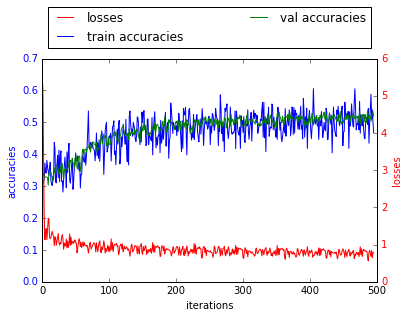

In [16]:
# Visualize the loss and the accuracies for both training and validation sets for each epoch
num_train = train_data[0].shape[0]
visualize.plot_loss_acc('hoc' + str(HOC_NUM) + '_train', train_losses, train_corrected_accs, val_corrected_accs, learning_rate, reg_strength, num_epochs, num_train, xlabel='iterations')

Below are more trial runs